<a href="https://colab.research.google.com/github/rng70/Image-Caption-Generation/blob/main/ML_Project_On_Bangla_Flickr8K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pushing the notebook to the repository
---

After making changes to your notebook, please commit and push them to the repository.
1. To do so from within a Colab notebook, click `File → Save a copy in GitHub`
2. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository
3. Please push it to [GitHub - rng70/Image-Caption-Generation: image caption generation using rnn and cnn](https://github.com/rng70/Image-Caption-Generation)


# Preprocessing

### Mount Google Drive
---

We need dataset before any kind of analysis. Here, data from google drive is mounted for making dataset

* Folder Structure: <br>
    &nbsp;&nbsp;&nbsp;&nbsp;/My Drive/flickr8k-dataset/{dataset-directory-name}
    <br>
    <br>
* Available Dataset: <br>
    01. &nbsp;&nbsp;&nbsp;&nbsp;Flickr8k_Dataset/
    02. &nbsp;&nbsp;&nbsp;&nbsp;Flickr8k_text/


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Set Up

In [2]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 106.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.8.2
    Uninstalling tensorflow-datasets-4.8.2:
      Successfully uninstalled tensorflow-datasets-4.8.2


In [3]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.0 MB/s eta 0:00:00


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 115.3 MB/s eta 0:00:00


# Import Libraries

In [5]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

# Data Handling

## Load Data

In [6]:
# Define the path to the Flickr8k dataset in your Google Drive
flickr8k_dir = '/content/drive/MyDrive/flickr8k-dataset/flickr8k'

In [7]:
# BAN-Cap_captiondata
captions_list = []
def flickr8kBangla(path = flickr8k_dir):
  path = pathlib.Path(path)

  df = pd.read_csv(path/"Flickr8k_text/BAN-Cap_captiondata.csv")
  # print(df.head(5))

  cap_dict = collections.defaultdict(list)
  for index, row in df.iterrows():
    fname = row['caption_id'].split('#')[0]
    cap = row['bengali_caption']
    cap_dict[fname].append(cap)


  # captions = (path/"Flickr8k_text/Flickr8k.token.txt").read_text().splitlines()
  # captions = (line.split('\t') for line in captions)
  # captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  # 
  # for fname, cap in captions:
  #   

  train_files = (path/'Flickr8k_text/Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flickr8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]


  for fname, captions in train_captions :
    for cap in captions :
      captions_list.append(cap) 

  test_files = (path/'Flickr8k_text/Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flickr8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

train_raw, test_raw = flickr8kBangla()


In [8]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [9]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/flickr8k-dataset/flickr8k/Flickr8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'\xe0\xa6\x8f\xe0\xa6\x95\xe0\xa6\x9f\xe0\xa6\xbf \xe0\xa6\x95\xe0\xa6\xbe\xe0\xa6\xb2\xe0\xa7\x8b \xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\xb0 \xe0\xa6\xa4\xe0\xa7\x81\xe0\xa6\xb7\xe0\xa6\xbe\xe0\xa6\xb0\xe0\xa7\x87\xe0\xa6\xb0 \xe0\xa6\x89\xe0\xa6\xaa\xe0\xa6\xb0 \xe0\xa6\x8f\xe0\xa6\x95\xe0\xa6\x9f\xe0\xa6\xbf \xe0\xa6\xb8\xe0\xa6\xbe\xe0\xa6\xa6\xe0\xa6\xbe \xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\xb0\xe0\xa7\x87\xe0\xa6\xb0 \xe0\xa6\xaa\xe0\xa7\x87\xe0\xa6\x9b\xe0\xa6\xa8\xe0\xa7\x87 \xe0\xa6\x9a\xe0\xa6\xb2\xe0\xa6\x9b\xe0\xa7\x87'
 b'\xe0\xa6\x95\xe0\xa6\xbe\xe0\xa6\xb2\xe0\xa7\x8b \xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\xb0\xe0\xa6\x9f\xe0\xa6\xbf \xe0\xa6\xb8\xe0\xa6\xbe\xe0\xa6\xa6\xe0\xa6\xbe \xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\xb0\xe0\xa7\x87\xe0\xa6\xb0 \xe0\xa6\x

## Image feature extractor
We will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so we can use the last layer of feature-maps:

In [10]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 [==============================] - 0s 0us/step


In [11]:
# function to load an image and resize it for the model:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

`load_image(ex_path)` returns a single image tensor with shape **(height, width, channels)**, where height, width, and channels depend on the image. The `tf.newaxis` expression creates a new dimension of size 1, which turns the image tensor into a batch of size 1 with shape **(1, height, width, channels)**. The `:` expression then selects all elements along the remaining dimensions, effectively creating a batch with a single element that corresponds to the image.

In [12]:
# The model returns a feature map for each image in the input batch:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


## Setup the text tokenizer/vectorizer

In [13]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [14]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [15]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'একটি', 'একজন', 'কুকুর', 'এক', 'লোক', 'আছে']

In [17]:
t = tokenizer([['একটি বিড়াল আছে '], ['আমি কুকুরকে দেখলাম']])
t

<tf.RaggedTensor [[2, 4, 1480, 9, 3],
 [2, 2662, 236, 1, 3]]>

In [18]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [19]:
w = index_to_word(t)
w.to_list()

[[b'[START]',
  b'\xe0\xa6\x8f\xe0\xa6\x95\xe0\xa6\x9f\xe0\xa6\xbf',
  b'\xe0\xa6\xac\xe0\xa6\xbf\xe0\xa7\x9c\xe0\xa6\xbe\xe0\xa6\xb2',
  b'\xe0\xa6\x86\xe0\xa6\x9b\xe0\xa7\x87',
  b'[END]'],
 [b'[START]',
  b'\xe0\xa6\x86\xe0\xa6\xae\xe0\xa6\xbf',
  b'\xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\xb0\xe0\xa6\x95\xe0\xa7\x87',
  b'[UNK]',
  b'[END]']]

In [20]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] \xe0\xa6\x8f\xe0\xa6\x95\xe0\xa6\x9f\xe0\xa6\xbf \xe0\xa6\xac\xe0\xa6\xbf\xe0\xa7\x9c\xe0\xa6\xbe\xe0\xa6\xb2 \xe0\xa6\x86\xe0\xa6\x9b\xe0\xa7\x87 [END]',
       b'[START] \xe0\xa6\x86\xe0\xa6\xae\xe0\xa6\xbf \xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\xb0\xe0\xa6\x95\xe0\xa7\x87 [UNK] [END]'],
      dtype=object)

## BERT Tokenizer

In [21]:
import tensorflow as tf
from transformers import BertTokenizer

# Initialize the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize the captions using the BERT tokenizer
max_length = 50
tokenized_captions = bert_tokenizer(captions_list, padding='max_length', truncation=True, max_length=max_length)




In [22]:
# Create the vocabulary
vocab = set()
for caption_tokens in tokenized_captions['input_ids']:
    vocab.update(caption_tokens)

# Convert the vocabulary to a word-to-index dictionary and an index-to-word dictionary
word_to_idx = {word: idx for idx, word in enumerate(sorted(vocab))}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [23]:
# Tokenize a single sentence
text = "আমি বাংলাদেশে থাকি"
tokenized_text = bert_tokenizer.encode(text, add_special_tokens=True)
tokenized_text = tf.convert_to_tensor(tokenized_text)

print("Original text:", text)
print("Tokenized text:", tokenized_text)

Original text: আমি বাংলাদেশে থাকি
Tokenized text: tf.Tensor([   101    938  37376  27470  11199    964 105069  12235    102], shape=(9,), dtype=int32)


In [24]:
tokens = tokenizer(text)
print((tokens))

tf.Tensor([   2 2662    1    1    3], shape=(5,), dtype=int64)


In [25]:
print(type(tokenized_text))

<class 'tensorflow.python.framework.ops.EagerTensor'>


## Prepate the Datasets

In [26]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [27]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break
  
print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [28]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)
  
  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [29]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [30]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [31]:
test_ds = prepare_dataset(test_raw, bert_tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Cache The Image Features

In [32]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [33]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

188it [30:24,  9.70s/it]
32it [05:22, 10.07s/it]


# Data Ready For Training

In [34]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [35]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [36]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [37]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 22)
(32, 22)


In [38]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  2 346  47  22   5  87 826 232  22   5  15  28  30  79  22   4  23   4
 384  38 587  11]
[346  47  22   5  87 826 232  22   5  15  28  30  79  22   4  23   4 384
  38 587  11   3]


# A Transformer Decoder Model

The model will be implemented in three main parts:



1.   Input - The token embedding and positional encoding (SeqEmbedding).
2.   Decoder - A stack of transformer decoder layers (DecoderLayer)   where each contains:
* A causal self attention later (CausalSelfAttention), where each output location can attend to the output so far.

*   A cross attention layer (CrossAttention) where each output location can attend to the input image.
*   A feed forward network (FeedForward) layer which further processes each output location independently.
3.   Output - A multiclass-classification over the output vocabulary.


## Input

The input text has already been split up into tokens and converted to sequences of IDs.

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The SeqEmbedding layer defined below:

* It looks up the embedding vector for each token.
* It looks up an embedding vector for each sequence location.
* It adds the two together.
* It uses mask_zero=True to initialize the keras-masks for the model.

In [39]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

## Decoder

In [40]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [41]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [42]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [43]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

## Output

In [44]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

In [45]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 938/938 [00:20<00:00, 45.78it/s] 


Uniform entropy: 8.52
Marginal entropy: 5.99


## Build The Model

In [46]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [47]:
@Captioner.add_method
def call(self, inputs):
  image, txt = inputs

  if image.shape[-1] == 3:
    # Apply the feature-extractor, if you get an RGB image.
    image = self.feature_extractor(image)
  
  # Flatten the feature map
  image = einops.rearrange(image, 'b h w c -> b (h w) c')


  if txt.dtype == tf.string:
    # Apply the tokenizer if you get string inputs.
    txt = tokenizer(txt)

  txt = self.seq_embedding(txt)

  # Look at the image
  for dec_layer in self.decoder_layers:
    txt = dec_layer(inputs=(image, txt))
    
  txt = self.output_layer(txt)

  return txt

In [48]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

## Generate captions

In [49]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 6us/step


In [50]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [51]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)


একজন
একজন দিয়ে


# Train

## Losses and metrics

In [52]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [85]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm


In [90]:
def batch_bleu_score(y_true, y_pred):
    # Remove the start token from y_true and y_pred
    y_true = y_true[:, 1:]
    y_pred = tf.argmax(y_pred, axis=-1)

    # Convert the integer sequences to strings
    y_true = tf.py_function(lambda x: [[str(w) for w in sent if w != 0] for sent in x], [y_true], tf.string)[0]
    y_pred = tf.py_function(lambda x: [str(w) for w in x], [y_pred], tf.string)[0]

    # Compute the BLEU score for the batch
    return tf.py_function(lambda x, y: corpus_bleu([[x.numpy()]], [[y.numpy()]]).score, [y_true, y_pred], tf.float64)




## Callbacks

In [53]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [54]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)




আছে
হ্রদের জ্যাকেট ব্যাক্তির আছে গাছের বিল্ডিংয়ের নৌকা দিচ্ছে কাটতে



In [55]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

## Train

In [95]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [94]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


InvalidArgumentError: ignored

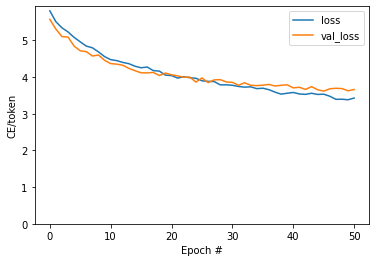

In [58]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

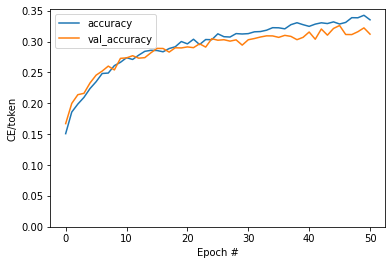

In [59]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Save Model

# Attention Plots

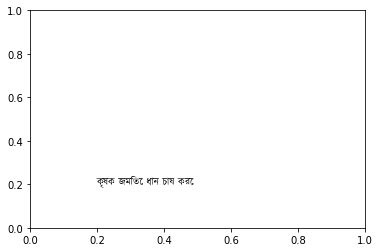

In [77]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

prop = fm.FontProperties(fname='/content/Kalpurush.ttf')
s = u"কৃষক জমিতে ধান চাষ করে"
x = 0.2
y = 0.2
plt.text(x, y, s, fontproperties=prop)
plt.show()

In [61]:
result = model.simple_gen(image, temperature=0.0)
result

'একজন লোক একটি সার্ফবোর্ডে চড়ে একটি সার্ফার'

In [62]:
str_tokens = result.split()
str_tokens.append('[END]')

In [63]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 8, 49]), TensorShape([1, 2, 8, 49])]

In [64]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [65]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        ], dtype=float32)>

In [78]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i],fontproperties=prop))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

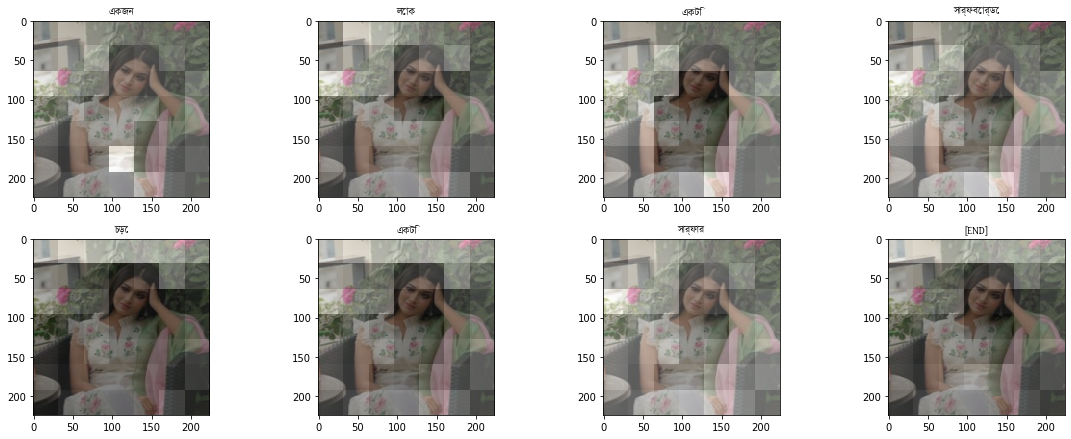

In [79]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [81]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  print(result_txt)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt,fontproperties=prop)
  t.set_y(1.05)

একটি কুকুর বরফে খেলছে


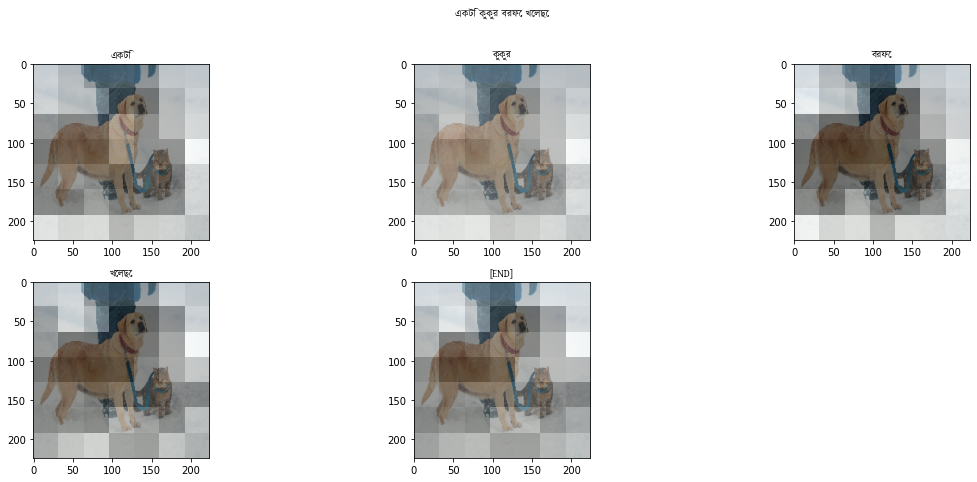

In [96]:
run_and_show_attention(model, image)

In [70]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

In [72]:
! ls

drive  sample_data  saved_model  test_cache  train_cache



# Try on Own Images

In [73]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


একটি ছোট ছেলে একটি মাঠে দৌড়াচ্ছে


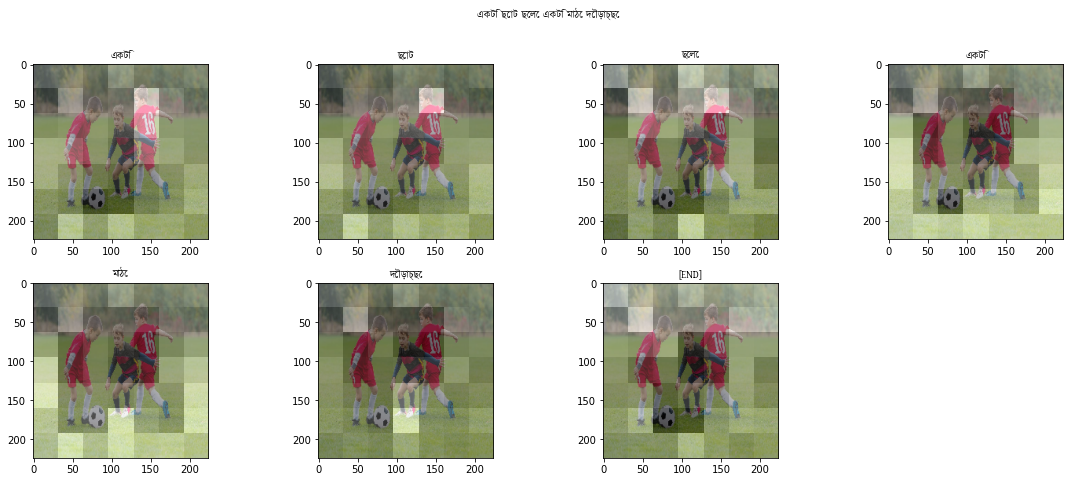

In [97]:
image_url = 'https://cdn.firstcry.com/education/2022/05/04111910/522565846.jpg' 
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)

একটি কুকুর বরফে খেলছে


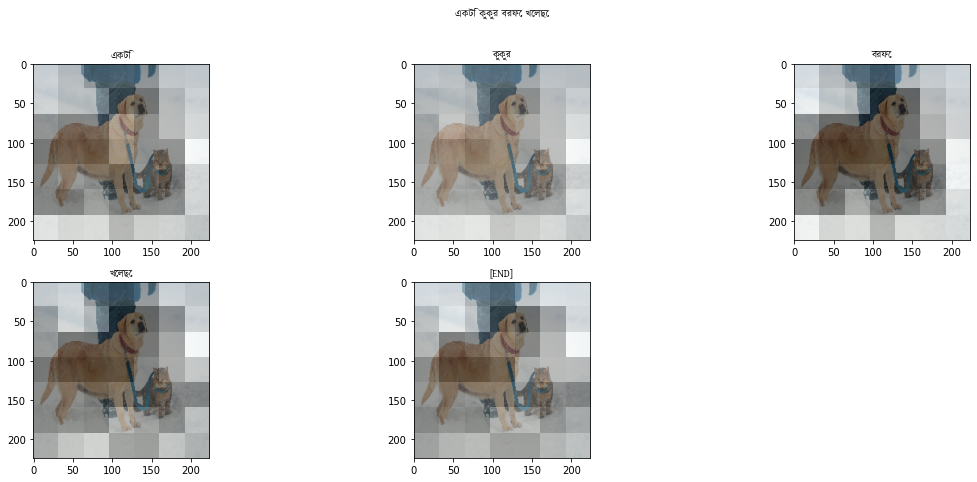

In [98]:
image_url = 'https://img.freepik.com/premium-photo/human-with-dog-cat-walks-snow-winter_416511-7073.jpg?w=2000'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)

11312/11312 [==============================] - 0s 0us/step
একটি ছেলে একটি কাঠের মেঝেতে বসে আছে

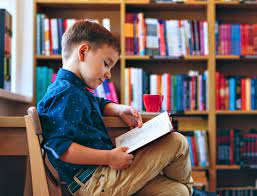

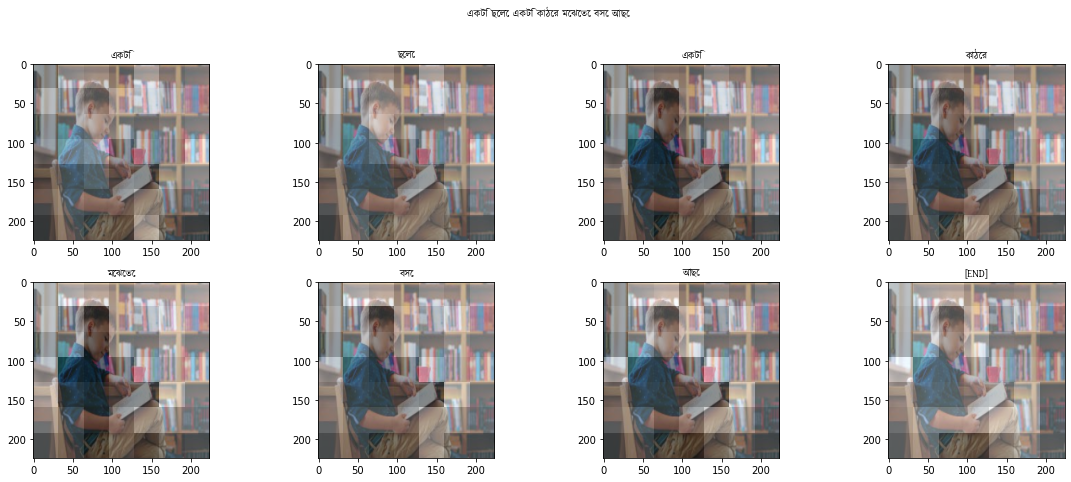

In [101]:
image_url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTExMWFRUXFxgVGBcYFRcVGBcXFxgXFxcYFxUYHSggGBolGxcXITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy0lHyUvLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAMQBAQMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAFBgQHAAIDAQj/xABGEAABAwEFBAYFCgQFBAMAAAABAgMRAAQFEiExBkFRYRMicYGRoQcyUrHBFBUjQlNicpLR8BYkM+FDgqKy8SU0Y3MXg8L/xAAbAQACAwEBAQAAAAAAAAAAAAADBAECBQAGB//EADwRAAEEAAMEBwcCBAYDAAAAAAEAAgMRBBIhMUFRYQUTInGRsfAUIzKBocHRUuEzcrLxBhU0QmKCJFOS/9oADAMBAAIRAxEAPwC6IFcljI1Q+yF/2lNoxdM4qAeqpalJPaDV03Pe6LS2VJ1GSk7weFF0BpB1q0PQese2jNn0FBkese2jDGlBh2I8iqb0j329ZnQWiM1GZFKbXpEtO8p8KY/SZdzr7uFtOIgkmq4tlwvtALWghJ0NKxwscCXDefNMOnohrTrQ0+SbU+kK0Henwroj0gWj7tIqGaktWcVY4WLgpE706p9IFoG5NdkekJ/gmk5FkTUhqwpoTsPDwRGyPKbk+kO0cE+JrU7fO+wj991Lrd2pPGuqrqTxNDMUPBFBcjyNv3R/ho/fdW//AMhOb20H99lLgutPE1781p4mqdTDwV7emP8A+QXPskfvuottZtIphhp/ClRVEg86RvmxPE0xekKylViYSnlVDFF1jABoTquOctNbdyHN+kxf2SB++yuyfSQr7NPj/akI3Q4NYo7Z9hLSqzKtPVCBzzMU67B4cNzEafNLddiQcpGqJ3vtibQjAUhImcjUW67+DM9ULB3KzpYbs/OuybNzojImxim6IbpXSauFpwc2rSoyWW67WbbNbZJbSG5EEpMTSimx8zW/yPmatnOzMV2UbcoR87VWon/uXImYkfpRU7cqMYk4jxJpMFj51umxc6BJHHJ8SNG5zNWik2r2sbVmplJPOvLNtK0VhIYSCSM++lT5DzqRdlkh5H4h76H1ETRbbHzP5RDI9x1Csy97SUMKXAMCYOlIVn2+WMw2lPZl8Kd9ok/yrg+78KpNtmg4KCORrs4vVVxUr2EBqfz6QHCIIkaRiyqO9tdiTAbCTuI1HZScGTXRDFPnDR+ifylhO/cPoEas97kKK1/Sk+3nUtV/IJnoEfvupeFnrqizc6vVKGjkmL+JB9mny/Sspe+Tc69qNOKLnfz8Sj+zf9Xuq0fRx/UtPaPjVRXZaC2rEOXhOdWr6KbWlw2hSd5GXiKLIPfBKMI6j1xTEn1j20aY0oKg9Y9tGWtKiHYolSG+sfK3p0wKqPcVzItzWF5SsKEmAMuNeWxX849+Bfxrv6N7SAlWIx1T7zV4cvU9rZZ81R9ifs7aH2QLZr0dWd9LqlrX1XFoABjJJpZvO50NBzDJKHCjPgDVqbCPAi0wcunWfGq62oVC7Sng7PjBouGja5t1f90fE9mYt1A02abgjmx+wDdqY6VbqgZiBH6Vz2k2SYsywlL+6YPWOWuQpi2Sths1gQT6zplI+7kJiq92htyy4vGTjX1jO6SMKfyzlzFIVbarVOzFrJ35fh3BSW7RZG5K1OKECAlKZJIkxJyGmdEbFZrE8JFqCBlIUDInSerHgTSGtCySTpOEds6c4rmHQMhvgn4TUCMAURaoZcx00VhruNItTbIWFIWUwtMEEHgRl/zR/a7Y1mzMdK2VSCBmZ1MVV903w4wpJB0IUN4EaZVaNr2yYt9hUnJD6QCpuciAfWbO8ctR51VsbQ1wO3cue5+YEbN6Riij+1balWZgJSSctBNCQinax+oj8IrPneYgH1dJ2E28Kq3rE4pYSUlMneDVi3EhZux1twdWVJSd8TFZtEsAJMAdcZxyphCQqxQBTMWKM+H2V8X0y/lEloS2f+PmUp7M7B2F5hKlLOIjPrHI+NcNrPR+1Z2FOsFS1JzKZnLfXC6mkoUtM6K48RTJci5UtJMgoIiZrWjDDGHkeu9YUgLcQWA6X9O5Vns1darW4ltJCSqYJ5U9NeitzCCp8A74TlXC60JattngQCVCP321aJcMVxhie0PaKvmi4lz4JnRE3R21X0VQI2GX0ymulT1U4pjnGlRto9mFWQJOIrSRMgZDTI+NWC5dYctCllZBCYgZTmDnXLa7OxqGuQ8o/ShtwzbIcN+ncukxPw5DuF9+t/ZVALUnAhY+scMcDR+6dnn1npEolLZBUaVkj+XT914j/URVybEYhZ3wcpg/6RVfZQRpwTQlDWFzhdGvVIVfKcbCwN6cqp51ooWUEZjWrjBOFIH3aWn2kfKXCpAUYz8KT6NaCx2m0gfRRPG6SRrQa0KR09ldG08qbralvc2BkK0cYbAPUFbGHwJm31670p0hM3BFoOtju/KWUxUhpApgaZZ6QnBu0rk260FKwog86ynuqxwW57ARl7W3l+6E9ByrKO/LOQrKBndwV/8ALx/7AhmzrSVKcxCYTlyM1ZXosuhTSrQs5pUEx5n41WOzJ6zn4fjV1bAH6Bf73VpPPv65LADB7GHb7+63Qev30ca07qANev30db0qINiHKq4tR/nHtPUXr30N2LVkP83vNSrcr+ce/Av41r6L0ArEicl/7qjqetwpYN9/1KBJ1eJDjuA8gifo7WcVqT/5JoGm7A/erjK/VUsKUOKUpxEZccMd9MeyYw261jQFU+VQLrXhvt0by2cPaRH60xhAWRVwsInSDicRmG8NPi0KVtZbA2I6ojJIgAD1yUpHABCB2VVttt4W4VGTIJJO9Q0PYM8uynnbBpTjx/LHCVGe+KG2LYsuKASNdO86ClXkNKI1pcEoO2uREZTllz18KEOa8f3NWfbLns6FFhMLcT1SQBgxDVIUT1j2ClVy62zKgN8RwO8RuobJ2klElwj2gE70uIUrnUhp8gggxGh08KJs3YSY41tb7iUIAznPsqTI26KhkMlWF1Zvae0VYT17JYYaWsEggDKqocZKDpw85Pup/wBoM7Gx2Ck8RC12Vp2FOYd5Ltdq8vXaVl4JQAoHGDnyFOl2WhD9kVgUUhJIOXAmqftBwqnmPdVmbCrmxPDfJNNQwMghzM3F23mB+FOJJdKWnZTfMrldGzXS4nOkiSco4URsNz/JSp1xwFATBy4ms2MtqOiMrEha9TnrUvaFaV2V0Yk+rOo3GnoC3q2tKycUCMS480nWggW2zqnLEY74irSbTIqqr1bKVMrBnCtPhnVpWNYIEHcKrBmEY+Y+qY6WaBi3c6P0r7IeEw/E6g0Hvu2NpZWhwwSSlPM55UXfdHypKc5idMvGkjbdUmJzS5P78aM4dtvP8LOHwkjdfmk+0MwzaRHquz5g1aWxclt38CfcKql54lNs7j5CrU2AcltyPsk+6uYDRvgPNaBc10T8vH7hBLYohpZGRAy7qUbqfJKlKMkzTfbxDbg7ffS3sxZwVKKk9UhUVl9HvDWOv9Q8imw337H8iP3XG12gE9wr0ugz213vJtMpgfVrg2BBr0nR8gN6b1k/4jgMj2AGtCuRtJDnKPjUezgqVAiTUh2ykry0MxXNixONrlQyzrzcjm53DmfNezm/hs7vspfyFftJrK36YcB417QrKVzpauS0LSo4BMwD2TV4+jh3FZnJEEHMcMhVH3IIatCwOslIIPDOro9FCf5Ras5VBPbhFaBFzErzAm/8cR81Pa/qd9HkaUCs/wDU76PI0qYBoulKq22T8sdO6FCuuwTSWy2CVJXK8U6QTSv6QL1dYfUWzEqVNKqds7UN48KCySTJlAFWd54ormRh+ck3Q3DgFYl7NPItTimVLzXmRwitdhLE985hx0H+mshR9oIMfE91IiNtbWN48KYNhtr7Q5b7OhZ6q1lJy3FCh74o0U0zGdXlFXxN6ldiBFM4Ps5gB86Gif7fdoLgAMmfOmMsdE0QnJfRrIP3g2qKmWK5UJcU4eOXKh1+Wk4gUjRQPbB0ocg0JV4ndoBVjs0hS7Q4HD1kAKbBQCAFkhJxazkeByMzBozeGzaUJSE9/MnM1PujZ91p9x1aRhVGEgzvVE8ICj4miVrVSIFCyKK05ZA9+hsJe+b0pSBhEjlnUdxPKiFqJ3a0sPXmVoDzZ3wUnWRqkjcRVQwnVRnANLy/roHRKcTlGcAanTM/vSitvsJVZGEKkFKROWcihe0N/hlhJA67nqpO4DNRPLd31K2j2jeZsjTyYKlRM86s7NbKG/RBzta4u4bUGvS51AFSApRkQmNadNjQtmyugp6yhMHdI0quh6Q7TwTXRHpDtPAU7HJK2g6MEXe3lSVxMrZWuDXlpIqwNlG7RKxWdQKyQUypWuW+sSV4Z6xy7qCXltc6+jAtIiZyyNeWXal5CQhMQNJFEY5zjmeK13apUtDdGOPknraZIFnQtKwTKSUjXWn+43wUIMjNA3jhVEubWPqyMeH963G1r8cPH9aKx7Wty879ao2JeZ5RIeAG3hf5V7XjamkLSpagnONRvpH2ys8urUkEg4Tl2iq2t18uOqClFUjgTHhNFE7avAAQDAjPOgyTPDmlguiDw2Lo2sDXA6WCPH8I0LgalwYlddAxa6xpTfsHbW0FaVHCA2Eid8TVbHbV32U+FaN7ZvFQGEZkDTjQxiJxfZHjzR2iAAi9Dw0T/eIBS5GhnwJoJcjZQAFBUdbUcZonbHyGFK+tgnvquk7bWriPCkcLnLSGgbQdtcUd8jY3hxJ2Jrt7KlYcKD6saVwDKkgykjupe/jS08R4Vjm1loUCDEHKtbDYqeH/AGA/9j+ClMaYcUQS4iuVplRakEiDJ5Z8Ky2uJcGElQ1Oh7qSLJb1tmU5Hxqb/ET/AB8qTdhml5fZ22nj0mSwNyjQVt/ZHPkCPbV+U1lAv4gf4+Ve0Tqx6H7oXtzvX9l0uU/QWr8A+NXN6JT/ACR7v9oqlLjJKHUTAUACeAq5fQ87isLnJZSOYAGdGA9675fZY2uQFGLKPpKODSg9kHXovuorBQV5TqqT2qu1FotS0rJEKVpQReyDQQTiM7s6Yr1c/m3PxKrS1LGAxTODijMVkfq8ysPpPFTsxBa1xA7PkEjW+5lsoCiQQeFH9g7tCVtW1ycDToUEAAlzBnIJIiFQO40XTZUOJCVCRl8akXo+hhtLQySkJAACtRkcgCDvzneaJBhGOkJd8IT0s88eEikBBdITWmtDbp4BWSzttY3hhS7gUfquDoySdwnInsJqDed4JSRPGqPt9oCgcyTJnPKNwwxI3+Ira7donEDo3FKUjQEmSn9RSeNwobrEb5J3A4vNpLpzX0IHgpA7KCXiIml3ZHagLbCFGVIy7QND3iD31LvS9UnQ1mSatWtCKctGlgrE0Ft9yM2VLryRIAKimfWWpWU96vCurVsHSYUmVxijPQ6dtC/l6Sh5p4y4UkesDiUcx1dRCgKGwECq70eSjrexKN5OreWVq1gADcANAP3vqxTssq8LK00lYRhSFEkTSQqzVb+xJhI/9f61eU25lcUkfhcUlWL0PKcQpQtEKCiMxIyoVf8A6NnrK0t0uJUlJiAIJ86uvZ9coc/Gr30v+kRf8m7+JNP4VnWRNLtpCVxZEcrg0aBUKEca7Bmi103Qm0W1plaiEuEzGvGrB2n9HVmYbBbWuZzkzVZh1bS47ArYb3zgwDUqrU2etvk9Wvs/sbZhZS64MZUgqz3dlJirtQokgx1oAoJJ0PEX8kxIwMjfI7Y05T367PBLnQV3st2LcVhbSVHgKnXhZcCcQO+K6bKbWCyO4lN45EcIph+GkZWakozFxvHZtC7RdDqJxNqTGsjSvbrutx11IbSVQQTG4VYD20Qtzhs6m8AcE4hqP3NabLNJsttdaSZGSROulRHA6QkNOwa+BV55Oo+Ma2G8dV3vRMMLG8IiqfS1nnV0Xvo5Vd3y2FO9VOid1ZmDflJatV2DOIZmB1H39cECDVdEtViQ4VBKUEmt140EhacJG41qCN7hYGix3SxMdlJ14L3oa9DVd7K06sgJbJnSu7lmUhWFYKTzoQsuyjamS0AWdBz086UPoq9rtNe1OR/BVzM4orsBZkuF1KhIMCrm2EsiW7O6lIgYj7hSmy02hRUlCQTqQImmC4r9bZQtCknrEmddaZ61jm1vShw7280XsqetRSMqCWC8mlKyUO+jYIIyI0qwqtEOS96oy/V/zTv4le+uPSfRntra/M7U6Pvq99drqs8qSNySFqPJJBjtOnfTGEssocT/AFFYnSYHtDr/AOP9IRiwWPoQFuetHVRqJG/LePCuKlgIV0xAWOskk5jXz/SulvvA4lKAgCZVlKjlCRJgDPlSXed6JESrGeCchPNW/U6cTnWtTYWa6JZnWT5QSSAKHIamhw1Kk31gcaJUZUlUBz2tOQBHLWlZSCmRkQd8e7hU1Tq19ZUADQaAb4ArVpY0Ofu3/wBqQmqQ3sWnFbG0vLnti2nMSQSN4Gsb8v3pTtYrW26kEGSTSO+2UZgkZgyDoRocte2mfZy0NOmCgdLE4hAkjUkZSdNJ7qzJcIZH0PX7LcwGJZkonXcK28gdx5HbuN6JvtWzbpaNokDCgqbj1idx5J1y35UoXJYUOv8AXJkie3jVwWV4uWVMQSU4TPZVafMrjSy5IAQsiPunSPKn8PBGyCSM/wB69aK+Ge6XGRl7bF1VWBe/8lCLcnA6ts7jl2VZexqpiPYquNv2C2tt0aLT5in70evSB/6/1rCmZlkaOacxbQx0gGxGtmrx+kdZjRalT2moPpF/7N7tFDtnXf8AqTgnXF7xRL0gibG6kZqJSAOJJyFO4D+C21ndIj37wOX1aPuqx2TWPnOzdp9xq49sz9GO2qhuC71s2+zuOBCEgkrUXG4GR161WftRfdmWkBL7KzOgdQT76HjHB0L65o3R8MjMQwuaRrwPBTLvRFiCf/Gaq5xWDETuX+lWlZX0qshKSMkZicxkdaqu3r+jc/HVIgS1l/o/CtjCfYpv5x5FQH+tGWRM+db2OxMqtoQEgpwTHOuKnc0Cp10sxa5OSsJ8K2cU3QetyxejXUK5hSbsQkWxmBHUV7017ZjF7T2+4Vl0OpNtaA3IVPiK8Yk3r3n3Cs3DDR3/AF8itjHfG7+ZMd86L7KREAl1UD6tPd9nqr76F7JpaLjuID1Br2ViRGnGlu4SbqonOo6VsQi5wcSOpAAImNdKE7VBXyg4UzCcxTw+43hbCIyUaTdobYlu0KJ3py869JE53+Xkt1N/deNxwB6VF6W2/P8ACZfR/BcZSR9U+8VE9IjRDyglOUDPhmakbAOS80eIV8K7ekG0IC3Uk5lOXnWf0Z/qXdx+y3v8Qn3Te5n3SD0XZWVmOsrUzLzFKaLyfb0We+pTG1ro9ZINZbLPQd5isnRb+oTNZttEfWSRTRd+2zJRAWQY0qsG7PTpsHsqzaVKU8vA2nLqxiUo5wCQQkAbzxFSLvsrjqO1sQtWJ184cyoqPxkncKkPXmyyyrCrHhUAYkYlajmUjt99Fb3uphl1zocYHRrQQpQUZJEQQBlANV/ebaSBEoRj9WZUowBCeOc56Ca2Oj/d4YPGp1H1Xn8fCJMa4O0HZPyr9l47ejrxUtxX0aSCE/VK5OAR2yT2c65XeycYUQCQdCJHeN4ruzd5VCAIQme9Z9Yzv4dgosGEpSAk9bOcsgMoM79T4UxHA95Bk3fU/gbPrvVHzMYMrP7D1r9NyEW4xCRuzrhEeRyM86y0vYieEmOytmm5BOWXMA55ZDfQHOzPJCI0ZWi1JEGYmP3rUKyNqC+r6yTuMSDwO7Wt+nwEDx7K9eJS8lSczh4gSB8YqHkaHgVLAdRxCJMbUWyzoLTdoWOtIznIjgqQNZphZ2pXaVKHQYlKA6rWMkEbzkUjsmkq/EgqbcGi0x3j+x8qb9kL1FnAASM9aTxWIdASAL7+HH6rZ6J6zN1kbsum6jeuztAivkum2KuksYxBaXG88K0KQY4jEBiHMSKa/R2vqpz/AMMfGmi6r8acR1gkiNDBFTX7fZWxJS2DugAGO6lHNMpa/TRO4ucykgt1OnLbolPZy7lm3OPD1AVJ75FTdu3IszhO5SD4Gi1gtrASXGgAkqOISScXHM5dlAdunOlsryWxiUYyGvcKYw2VrMhO7X52ksUX9cZWjhXeABXiFWl7AhagSZCiKHpmQJ3ijFpBUgOKQQspwqBAmUqInlIAPfUMWcKUARkJJ7AJJ8BSTTQpfQzJ1zBKLpwB8Ras7ZNmLE65qHBkOSEYf92LypEtaB0bhHt/pTps1bgLuKD6yG1FQAJgbyYGQnfSWhYUhQM5qnQ6U2WZXDT/AGleCx0wmwczgdr9O7KQPpShrbno+2pVmE2ud8YaFvXggFIxaH40ZsFmX8pS5qnLdl41oYuRgbqR6Cx+jo3GqGw2V2uyydFeLYmZQT5iuri/+qJyjM+6vUMvm3JcKYQkRPaR+lSrcyo29txAlAmTumKzIJ25SSRrl8ja25oOsc88DY56hEL6OS+w0iIeUlwwYlNPd6JxBcb5pMeuN4qkoMYfOsqEtDjZWzgnhkbieSJ2Joy3nM5+6oltuIWm0qClEBKQSBqaIXVZnU9HKT1RnW6lPN2lTiWsaVADWNK3sHNG3A05w+I7xx8V5LpGKSTpMPDSRkrYa379i7bGsBD7aRPVKgJ4A1C9IqJeWeAHvNFrhQpLyXFJwgkk8pqHtnYVvOKLYxA5a86z+jZmNxbi4gCndy2+nWOkgZk1NM2d6Qvk44mso38yWj2POsrR9oh/WPFec9ln/QfBG3bvCtFjvSqoa9nSf8VHgr9Kxu92vtUfmFSE3yz9qj8yf1rFzyegvQ5W+io52cI/xUeC/wBKd7iuluzIOFS19IEk4oAHNIAka7zSkL4Y+1b71ppxui0pds6FJUFAgpkEEdUkajsqOteNvkuyNKSNpXV/Sx60KPenrfCKR0XsJSpTTZI0kZ/m1p92ibh2TvOfx+NVq6xhWpPsqI8DFaWFne0ENPPis3HQtdRcOSPpvWUlIBAMHwnee010L46MjOe7v8qBMOxMgHIjPdO/tqdZpPGtmLEufoVjPha3YoyCc/DSuw3V3eAUchG6e85+7wqK+4oTkJgaCBuFBrIiXmWloUA4Z3ZHu4VytQJXJ4CKwwvkfGTXrgVhAO45EZ5GlybB8f7owFEeCkMI6RPREgEHGknSR6wy5Ge6iVlsbg+uj/V+lL4cUIUNxmmWy2xEA4gJE6ga0liy4gV3fhafR5aM2496kptFobzCkkAgwFK3doogq8Tac1Eg7oyjlQ9dtbj+oj8woebYlCsSFpPEYhn50mLIretLO1ps7N6bbptK2CQFY0qiUL4gyCCO8d9HbTfC0MKcEpSlyYUAvqrMZZblQJ50kLvZJSkiTihMgGCSYAnQZ063RYlWhhFjcCkuLBCjHWSgHElRkDKAnXWRxqTe0XexEc1paQaI2qNZ9pnHCEpKVKJgDo8RJ5ADM063Js4+uF2gobT7KW04z2kiE+Z7KI3Bs7ZrEmGkyqIK1ZrV2q3DkIFHkrM/vSmWROGrisqWdp0YNPXyWjNgaQgoQhKUkEEAATIjPia+eNrGbW1aVNBbaUgqbSEpCSUt4essQBiUFJMjjX0cjyqjfTpd56Rq0iUg421xpjEZzzSE/lohLgdCqMogg9/ht+lpC+aXjnKe2irVqtyQAHEgDLSpGztlxMJOZoom78qzpcSMxa4A0nY4BVgkWgS7fb/tR4VBcvu2pVhK9/CmNV3nhXF27sxlUNxEd/CFD4nVo8pmWtXyfFPWwTPOq0O0Fpk/SHWrNtf9Ej7nwqpMOZ7TVsG1pzWFGKLhVFEBf1p+0Nbi/bT9oahJRXRLdN9Wz9IQA6Q7z4qT8+2n7Q1qb8tP2hrkGq26CuyM4DwXW/ifFb/Pdp+0NZWnQV7XZGcB4LrfxK6/Ia6pu6d1SgialNNUAyFOdUOCG/NnLyqw9gxhsxR7K1ecK+JpTCRTRsWvJ1PNKvIj4CqSOtqlrQ0qBtuAlSCQYVkIBidwnSdare9c3VmCCSJBEGYE+OvfVxbXWfFZXCNUAODtbUFe4GqmvxYdtRDQkwlJjOSMviBR8G7NpXLySeNFN281Es9nJz1oky4UjDIAJG+BIkAnsk+NRQzomTlqBkB/euDyEzAkntrab7oWPNYju2aPktrQ+R6viK3L5UkTXFFnVuOHvmsttkfbzcbUkHQkZGeelBdIQdd/rvRWx5hbd29eqaiCO3XMfpWzQWNDUMPmuofVpOnlxqocL3ri11KWqzpOeijw0PdXllY1Sd2nMVxdWpSIyBBkHeeRrm3a1AidBrxg69tRNRGmiLhyWuBOoRFNlTvo9c+xDr8Ep6JB+ssZkfdRqe+Bzov6PrI0rGsoSpaVJwk5wCDpOU86fbvQpwyRAOQ9+dINzE0tR+Vu5cNmtl7NZUgISVqB9dcKUCZ0GiN+g8abbI2TmABxPGOe/fXGwWIAZ/2os233CmGtypV78y9bbruE0vbTbYWKwJm0OgLIkNp67quxA0HMwKp/an0q221yizD5KycpSZeUObn1OxOfOuLlDWEq29q9urFYAQ65id3Mt9Zw8JGiBzVFVPeF5uXu4elAs7ZVKUYelKdQCTKYME6UnWKw5yZKiZJOZJ4knWmq5kYCDSks1bE9FCG6lSbZcdtsTMsBNpZTmSgEOJG8lvORzST2CgCdsXvZSBzmrMuO9+sEHIwSP8omoe2N2NZOJQmFpk5aKBz98+NThoo53U5ovU/RBxD3RUATVgd1mr+VrlsS41a209IDjM6aZVA2keDLKykHGhR/KDUnYQJDiRoAT5zU70jsDoSQNyp8Kv1MJhzhgsevJUf1sczo3Ov+yEi2dIxi4oqs1rz76ernXNm/yUlLIB7zQMH2S5N4lmdo1pbWVUrSDpXO0ghaoMAGtmXBiFdYBK8t1PNFv+SSlDWQAA2c23lWxesKJ51o7ZHiqQMu2tVNLbGY1zrv0y+trqN9cGUdy5r2PaA5r/lVb+K06B/2ayiEn2jWVTs8R4LQ9jHB/wD9N/CmN5V3SaXxfC/ZT5/rXovtz2Uf6v1pTqH+io9pj4/RMQo5si9DqhxR7iP1pC+fHPZT5/rTJsVb1LfSVACQpOU+zO88qq+JwGqkSscaCsF9AUkpOhBB7xVOizJsmTycbb8kKQYcQWnCkjPTOe2rixVWO0NlKrctkjqpQ4pP/wBuZP5lGuwUvVuJQsXH1jQFHdutJYU9Z19IhPryIW3ImVD6w1zoI0hKROpNE9lr2NldJIltQwuJPDs4g/GsvZlhTx6BeJvUDh92eFegkka1ged2lfhYMULpH5G7/WqmbHWBLr2Jfqo6wHFW7uGtPr6UmQQCPGla40htMjU0TVbK87iZDM/M5eswsLYI8jfnzK4WzZKyu5hJbPFGX+k5eVCLTsA4DLTyVcAoFJ8RPuo6m2xXZN486qyaVmx33USYWGT4mj5aeSUH9jbdoGwqdSFt9uWKIrRGyFt9U2eZIg428u/FkKdk3rWhvQ4taYGPl3geH7pU9FwHZfj+ykbF7OrsSFl91K1LwwhAMJw4vrnX1uA0oyxtI4HQy22kqJhKd5HEZwAJGdBmL0xHOpQvVKBi37joR37qX6193dJoYeMCst96dr42hslhbDlsdQ2oiQgHGsneEIGZE74jnVV7S+le2WmUWJHyZrTpFQp4jlHVb7pPOl7aiwWd1YUkqLql5lTinFKGplSyTllXNNlGSE6b6bdOK0SIw1ONoSiwFSitalLUTKlqJUSeZOZNFLJdvKjVju4QOAooxYxIFLPmJ2JhrGt2ITZ7BG6pyG4qUUCSd27s0qBe9rShJSNch465b8veKCLJUlymXOolxaxuSUJHFSsifA0UvS2Bf0OpQ2STzhEf7lDupUZvZaVJ6KEITHPu5nUk88uNG7qZUtt59WpUmOSZM+Zp7BdmdneEhjtYHkcD+yibLWuH/wDMKbdvW/oj2VXbasL43Z/Gn/bEYrODOqR7qaYzsPZzKvjXXOHjeAfEJIuRX8uRwSRS1ZrMlQkiTKqPXaqG1jhioJYnkxmd6vjS+BHvHKMb/CatkWRGIQIOGRUJ1ElWcQKJ2VwFQzGSTQoplTnfTh/ifJKn/SD+Y/0ro8okZmdK6E+t+JNcWrWkCMIOYzPKpovJPW+jGZB8IqrW2NSjdeGmg3Svs78rMVZUj55T9kKyo6pv6k57byKAV7WKryaqs5bUzbIrwusn/wAkeIw/GleaYLkXh6JXBwHwUKDNsTEG1WrNI22x6K1tOn1VoKFHhBBB8xTrNKnpFs+JhCvZUPAiPfFZ8Jp4vuT0oOU1tSjfdiwnpAJSr1uRO/v9/bQX1TlkeOhphua240lpeak5Z/WT/bTwoTelnCVqTnxBOeoB1762IXk9h20eSx8RGB71mw/QrqzfLqQIUFciM/KpKdo1b0DuV/agEEGpDLSljEowhOUnTWYA+sc9Kh8UR1IUx4qcaBx+eqMfxL9w+Irb+IvuHxFQmrECQpQ/CngNxVzzHZI10JK67mDjpTElAxOD2QNE8lk5R9WFTmBA3YeMDMRQRG9ITudlabPcuiL56s9GvgBlJ7BNSbst/SLw4VJOgxZAngDpNT7LYkIdDjy0oA9Ubpgz/lAy7xxow3c6S80kRGFTnbmQD7qQJZuC0RNJvI8EOW5h3VDtt4j1deO4UT2mu3AtGHJOBxa+xKTHZ1ikUHZuodEhxWaiMXjVaAFlHE4OwKP8qKwDhiJCeOep8qmWZiBzOtSlXd0aQpWRIBA91TLJYlKz0y14DifgKq59qoXawoGHEdAQO+uyrTCFL3qMJ5iInxy7qiuqBhCfUB/Ma4XrbEtIK1nP6o57gkfuK5rcyE40uVrt6Wh1zJAyA1URu8dTS6mXVY1yPu4tPDWolvtKVPAheLEkRy1lJB5ye+p9nVlTGTI1CBzFT7MgZQMhvPAZmB2U63XnZXd2JCiAeQlPunvpMsxnXh/z5UwNWwpaA3rOE/hg4j4R41zDlOZVlbmGVLDjSzaEkiUzJimS23kkwlZ6gERQhV2kjJxQoNtFZFNNYw6omYo0WNJe6iO3yO/eoxOEzNYTfYreNQBWqmMkEuBOhmKEK2aeJ1T40Tu1wKan62GltVtdk9c6nfQ4Q/M7KQFfEGPK3OCe4omi4HkkaHsNbP3A8BIIz1zoT8rd9tXjW3ytz2z40xUt3mHgls8OTJlNXe3et3EI3EJjI8zUmz3aVpxBSY7aFkGvAs8TTGbWylWjKKCN/NCvaTWUExq4nxrK7T0VOcroqtaxVeUNWXtHbPk0nsnzmgNMDghAHBPwoUu5MQbyrOC5E8c/caG7TtYrM590YvykK+Fd7A5LTZ4oSf8ATUi0ICklPtAjxEVljQ3wWltVRXjZ1NqDiO0fEeHlWrhU8UqETGcmPfRtCQUYFbsu8Ze8UKvGwBDaSNMUeMn4VpRv15pGWLQndvCHvskGCDi8f+aZbmYafZDCilD7clCtQc5M8Tx8RnMBbEOqsCMUSMs4+uB3Z9iTxryytrUrC1r9ZfCdwO749lMPIcLuq3rPaCx2UCwdyLosj/SBhCSHlZlZmEp3lKt+vrcyN5pxsFyNsWZKEZqX1lrORVrhMbhvA5VvYGDCEqcJAgKVIxEaq03mACeA511vG2KwFaRmqEITwKsojkMu2kZ8Q54op6DDNjPZ2rXZSwoWXHFjGYhIUMujn1s+KkH8tE7udClqWn1Upwk7plRCU+I8TUK1RYrIpbqz0iwlJMTAGQSlI3CfOo7FpKUBtBAk+t5+4Uu4uoJimkmlrtdbAqGx6xTCjwEgwfAZchW13MDCHnhDSBhbRvWcyJHfUe7bIiDaHTMqhIPIFRJPl31ltt5VhWfZ6o+qjUdUDfPGqnVEA0oLq0yp9xS3DCRmeEj6o5CvLdb8XUbEJ3n2v7VytC4QEHXUxuJk4ecCPOl6875H9NqCrer6qf1NSxhcVznAKTbr4DRwpGNzwSnt49lBbQFuqxOKJPuHADdW9lZGupOpOporZ2hRi4M2KuQu1KEC6MWoAHEnPuiujV1vj+mcY5j/APQpjZYHLs18qJMNjeM9w3VXrSqljdqV2UuIEuIwaiVE4e9UUw7OW5j5Slbq04UhWXrAZRHMmaYLvcTooAg5EajvyqBbrEizWhrowkMWhYSUnRtyR6p3AjOPumpGuqo47lDdsUqJblTZJwHPNM5ZHlQ6+bsxNLBTnGU1EcvS0tOuoxlQQtSZSBuMaUM+eXnX1FxZw4YE5A9xqxwTmG9ePJXbj2PbWhvTn81HsKSlEcBFAiMz2mmBGh76DdEjMlzyo8J1cUPEt7LBy/C4xW4TXYNNQCVqg8qmN2NiQC6rMTp/aj2efglNOI8QhhTWIbkgcTHjRZNms8+us5Tpu8K2V8lAS4MQGLxiuBPAqpriPFTf4U+9WUV/i+zcFeFZUWVa28khLrysrKshr1vUdopitmlZWUKTaEzBsPrina5P6DX/AK0e4VPJ07BXtZWY7atJqRbUgB10DTpFe81Bvb+ifxJrKym2bR8kKT4HdxQHpCmFAwRmDzplbgIQUgJ0VAECSMR7pr2so8yTg+JMd2uFSc/3lRawGAlUAkSRO4kZkc69rKRcmyh1521aliT9VR78Sa0UOqlW+D3dU6VlZQyrjYud8OHGGtENiEge88TUN1w/R9g95rKypUpYv+9XS50QVhT93IntNQbOYGVZWVoAANSFnOpzDpiit3uExPhoPKsrKC8BMtJRhp8hOUDkBlXezWhR1415WUsrFF7Q4Rh951rL5OJlE54XEqHaErivayit2oJVVWe8XJKsWa1FSjxJMnzopeDYUgqIz/saysrfaeyVhH40MarS9bKltKcM9ZOIzxkjL8orKygSjYmYCe13FcrX/SRU5P8AUR+D9K8rKqFPH5LRSzi/yVytB/lkfiPxrysrgo4934UKsrKyqqF//9k='
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)